In [1]:
import os
import numpy as np
import xarray as xr
from src.hls_funcs.masks import mask_hls

In [2]:
atsa_params = {
    'dn_max': 10000,  # maximum value of DN, e.g. 7-bit data is 127, 8-bit is 255
    'background': -999,  # DN value of background or missing values, such as SLC-off gaps
    'buffer': 1,  # width of buffer applied to detected cloud and shadow, recommend 1 or 2
    # parameters for HOT calculation and cloud detection
    'n_image': 107,  # number of images in the time-series
    'n_band': 5,   # number of bands of each image
    'blue_b': 1,  # band index of blue band, note: MSS does not have blue, use green as blue
    'green_b': 2,  # band index of green band
    'red_b': 3,  # band index of red band
    'nir_b': 4,  # band index of nir band
    'swir_b': 5,  # band index of swir band
    'A_cloud': 0.75,  # threshold to identify cloud (mean+A_cloud*sd), recommend 0.5-1.5, smaller values can detect thinner clouds
    # parameters for shadow detection
    'shortest_d': 0.0,  # shortest distance between shadow and cloud, unit is pixel resolution (default 7.0)
    'longest_d': 134.0, # longest distance between shadow and its corresponding cloud, unit is "pixel",can be set empirically by inspecting images
    'B_shadow': 1.5,  # threshold to identify shadow (mean-B_shadow*sd), recommend 1-3, smaller values can detect lighter shadows (default 1.5)
}

atsa_params['maxblue_clearland'] = atsa_params['dn_max'] * 0.15  # estimated maximum blue band value for clear land surface
atsa_params['maxnir_clearwater'] = atsa_params['dn_max'] * 0.05  # estimated maximum nir band value for clear water surface'

In [3]:
import glob
yr=2022
prefix = 'cper'

outDIR = '/90daydata/cper_neon_aop/hls_nrt/' + prefix

In [4]:
"""
Get the server base url
"""
from jupyter_server import serverapp
 
try:
    jupServer = [x for x in serverapp.list_running_servers()][0]
except IndexError:
    jupServer = {'base_url': '/node/ceres20-compute-53-eth.scinet.local/53953/'}

In [5]:
from dask.distributed import LocalCluster, Client
import dask_jobqueue as jq
import dask
print('   setting up cluster on HPC...')
dask.config.set({'distributed.dashboard.link': jupServer['base_url'] + 'proxy/{port}/status'})
partition='short',#'short','debug', 'mem', 'mem-low',
num_processes = 4
num_threads_per_processes = 2
mem = 5*num_processes*num_threads_per_processes
n_cores_per_job = num_processes*num_threads_per_processes
clust = jq.SLURMCluster(queue=partition,
                        processes=num_processes,
                        cores=n_cores_per_job,
                        memory=str(mem)+'GB',
                        interface='ib0',
                        #interface='enp24s0f0',
                        local_directory='$TMPDIR',
                        death_timeout=30,
                        walltime='02:00:00',
                        job_extra=["--output=/dev/null","--error=/dev/null"])
client=Client(clust)
#Scale Cluster 
num_jobs=8
clust.scale(jobs=num_jobs)
try:
    client.wait_for_workers(n_workers=num_jobs*num_processes, timeout=60)
except dask.distributed.TimeoutError as e:
    print(str(num_jobs*num_processes) + ' workers not available. Continuing with available workers.')
    #print(e)
    pass
display(client)

/project/cper_neon_aop/conda_envs/hls_cog_env/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


   setting up cluster on HPC...


<Client: 'tcp://10.1.9.236:37532' processes=14 threads=28, memory=130.34 GiB>

In [6]:
nc_flist = list(filter(os.path.isfile, 
                    glob.glob(os.path.join(outDIR,
                              prefix + 
                              '_hls_tmp/' + 'hls_ds_' + str(yr) + '*.nc'))))
if len(nc_flist) > 0:
    nc_flist.sort(key=lambda x: os.path.getctime(x))
    nc_f = nc_flist[-1]
else:
    print('ERROR: No temp nc file found')

hls_ds = xr.open_dataset(nc_f)

hls_ds = hls_ds.chunk({'time': 1, 'y': -1, 'x': -1})

hls_ds

<xarray.Dataset>
Dimensions:  (time: 66, y: 323, x: 323)
Coordinates:
  * x        (x) float64 5.176e+05 5.176e+05 5.176e+05 ... 5.272e+05 5.272e+05
  * y        (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * time     (time) datetime64[ns] 2021-11-03 2021-11-04 ... 2022-05-26
Data variables:
    BLUE     (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    GREEN    (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    RED      (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    NIR1     (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    SWIR1    (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    SWIR2    (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    FMASK    (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    SZA      (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>
    SAA      (time, y, x) float64 dask.array<chunksize=(1, 323, 323), meta=np.ndarray>

In [7]:
water = mask_hls(hls_ds['FMASK'], mask_types=['water'])

In [8]:
# HOT for land surface
num_l = np.logical_and(np.logical_or(water == 0, hls_ds['NIR1'] >= atsa_params['dn_max']*0.1),
                       hls_ds['NIR1'].notnull()).sum(dim=['y', 'x'])

In [9]:
rmin0 = 0.01 * atsa_params['dn_max']  # min DN value of blue band for computing clear line
rmax = atsa_params['maxblue_clearland']  # max DN value of blue band for computing clear line
num_valid = np.logical_and(hls_ds['BLUE'].where(num_l > 0) >= rmin0,
                           hls_ds['BLUE'].where(num_l > 0) <= rmax).sum(dim=['y', 'x'])

In [10]:
rmin = hls_ds['BLUE'].where(num_valid > 0).min(dim=['y', 'x']).compute()

In [11]:
n_bin = 50
bin_size = (rmax - rmin) / float(n_bin)
bin_size = bin_size.expand_dims(dim={'bin_min': np.arange(0, n_bin)})
bin_size = bin_size.chunk({'time': 1, 'bin_min': -1})

In [12]:
ind_bin = np.logical_and(hls_ds['BLUE'] >= rmin + bin_size.bin_min * bin_size,
                         hls_ds['BLUE'] < rmin + (bin_size.bin_min + 1) * bin_size)
num_bin = ind_bin.sum(['y', 'x']).compute()

In [13]:
x_bin = hls_ds['BLUE'].where(num_bin > 20).compute()
y_bin = hls_ds['RED'].where(num_bin > 20).compute()
ind_good = (y_bin <= y_bin.mean(dim=['y', 'x']) + 3.0 * y_bin.std(dim=['y', 'x']))
num_good = ind_good.sum(dim=['y', 'x']).compute()

x_bin = x_bin.where(ind_good).compute()
y_bin = y_bin.where(ind_good).compute()

/project/cper_neon_aop/conda_envs/hls_cog_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [14]:
order = y_bin.stack(z=['y', 'x']).argsort(axis=2)

In [15]:
order = order.unstack('z')

In [16]:
top_num = np.ceil(0.01 * num_good)
top_num = top_num.where(top_num < 20, 20).compute()

In [17]:
x_bin_select = x_bin.where(np.logical_and(order >= (num_good - top_num),
                                          order < num_good)).compute()
y_bin_select = y_bin.where(np.logical_and(order >= (num_good - top_num),
                                          order < num_good)).compute()

In [18]:
x_bin_select = x_bin_select.transpose('time', 'bin_min', 'y', 'x')
y_bin_select = y_bin_select.transpose('time', 'bin_min', 'y', 'x')

In [32]:
x_hot = x_bin_select.groupby('time').mean(['y', 'x'])#.chunk({'time': 1, 'bin_min': -1})
y_hot = y_bin_select.groupby('time').mean(['y', 'x'])#.chunk({'time': 1, 'bin_min': -1})

In [33]:
x_hot

<xarray.DataArray 'BLUE' (time: 66, bin_min: 50)>
array([[         nan,          nan, 650.35      , ...,          nan,
                 nan,          nan],
       [         nan,          nan, 808.75      , ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [         nan,          nan,          nan, ..., 787.6       ,
        787.6       , 787.6       ],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [         nan,          nan,          nan, ..., 916.89473684,
                 nan,          nan]])
Coordinates:
  * time     (time) datetime64[ns] 2021-11-03 2021-11-04 ... 2022-05-26
  * bin_min  (bin_min) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49

In [36]:
import pandas as pd
import statsmodels.formula.api as smf

def calc_hot(da_x, da_y):
    def calc_hot_np(x, y):
        ind_0 = x > 0
        num_sample = np.sum(ind_0)
        x = x[ind_0]
        y = y[ind_0]
        x = pd.Series(x)
        y = pd.Series(y)
        fitdata = pd.DataFrame()
        fitdata['x'] = x
        fitdata['y'] = y
        if num_sample >= 0.5 * n_bin:
            # compute slope of clear line
            mod = smf.quantreg('y ~ x', fitdata)
            result = mod.fit(q=.5, max_iter=5000)

            result1 = result.params.x
            result0 = result.params.Intercept
            slop = result.params.x
            intercept = result.params.Intercept
            if result.params.x <= 1.5:
                result1 = 1.5
                result0 = np.mean(y) - result1 * np.mean(x)
                slop = 0
                intercept = 0
        else:
            result1 = 1.5
            result0 = np.mean(y) - 1.5 * np.mean(x)
            slop = 0
            intercept = 0
        return result0, result1, slop, intercept
    
    def calc_hot_xr(da_x, da_y):
        ds_out = xr.apply_ufunc(calc_hot_np,
                                *[da_x, da_y],
                                dask='parallelized',
                                vectorize=True,
                                input_core_dims=[['bin_min'], ['bin_min']],
                                output_core_dims=[[], [], [], []],
                                output_dtypes=[float, float, float, float])
        return ds_out
    
    ds_hot = xr.concat(calc_hot_xr(da_x, da_y), dim='var')
    ds_hot = ds_hot.assign_coords(var=['result0', 'result1', 'slope', 'intercept'])
    ds_hot = ds_hot.to_dataset(dim='var')
    return ds_hot

In [39]:
hot_params = calc_hot(x_hot, y_hot)

In [40]:
hot_img = abs(hls_ds['BLUE'] * hot_params['result1'] - 
              hls_ds['RED'] + hot_params['result0']) / (1.0 + hot_params['result1'] ** 2) ** 0.5

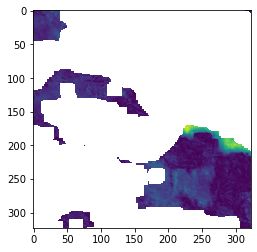

<AxesSubplot:>

In [58]:
from rasterio.plot import show
t=6
show(hot_img.isel(time=t).values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


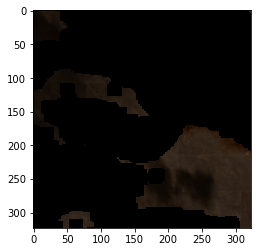

<AxesSubplot:>

In [59]:
show([hls_ds.isel(time=t)['RED'].values/10000,
     hls_ds.isel(time=t)['GREEN'].values/10000,
     hls_ds.isel(time=t)['BLUE'].values/10000])

In [50]:
hls_ds.isel(time=3)[['RED', 'GREEN', 'BLUE']].values

ValuesView(<xarray.Dataset>
Dimensions:  (y: 323, x: 323)
Coordinates:
  * x        (x) float64 5.176e+05 5.176e+05 5.176e+05 ... 5.272e+05 5.272e+05
  * y        (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
    time     datetime64[ns] 2021-11-09
Data variables:
    RED      (y, x) float64 dask.array<chunksize=(323, 323), meta=np.ndarray>
    GREEN    (y, x) float64 dask.array<chunksize=(323, 323), meta=np.ndarray>
    BLUE     (y, x) float64 dask.array<chunksize=(323, 323), meta=np.ndarray>)

In [ ]:
n_bin = 50
bin_size = (rmax - rmin) / float(n_bin)
x = np.zeros(n_bin, dtype=float)
y = np.zeros(n_bin, dtype=float)
ii = 0

# find samples on clear line
for i in range(0, n_bin):
    ind_bin = np.logical_and(data_blue >= rmin + i * bin_size, data_blue < rmin + (i + 1) * bin_size)
    num_bin = np.sum(ind_bin)
    if num_bin >= 20:
        x_bin = data_blue[ind_bin]
        y_bin = data_red[ind_bin]
        # remove outliers
        ind_good = y_bin <= np.mean(y_bin) + 3.0 * np.std(y_bin)
        num_good = np.sum(ind_good)
        x_bin = x_bin[ind_good]
        y_bin = y_bin[ind_good]
        order = np.argsort(y_bin)
        top_num = np.min([20, math.ceil(0.01 * num_good)])
        x_bin_select = x_bin[order[num_good - top_num:num_good]]
        y_bin_select = y_bin[order[num_good - top_num:num_good]]
        x[ii] = np.mean(x_bin_select)
        y[ii] = np.mean(y_bin_select)
        ii = ii + 1

ind_0 = x > 0
num_sample = np.sum(ind_0)
x = x[ind_0]
y = y[ind_0]
x = pd.Series(x)
y = pd.Series(y)
fitdata = pd.DataFrame()
fitdata['x'] = x
fitdata['y'] = y
if num_sample >= 0.5 * n_bin:
    # compute slope of clear line
    mod = smf.quantreg('y ~ x', fitdata)
    result = mod.fit(q=.5, max_iter=5000)

    result1 = result.params.x
    result0 = result.params.Intercept
    slop = result.params.x
    intercept = result.params.Intercept
    if result.params.x <= 1.5:
        result1 = 1.5
        result0 = np.mean(y) - result1 * np.mean(x)
        slop = 0
        intercept = 0
else:
    result1 = 1.5
    result0 = np.mean(y) - 1.5 * np.mean(x)
    slop = 0
    intercept = 0

hot_img = abs(data_blue * result1 - data_red + result0) / (1.0 + result1 ** 2) ** 0.5
hot_img = np.ravel(hot_img)

In [11]:
from src.utils.atsa_utils import Compute_hot
n_bin=50

def Compute_hot_xr(ds, rmin, rmax, n_bin):
    hot_xr = xr.apply_ufunc(Compute_hot,
                   *[ds['BLUE'], ds['RED'], rmin, rmax, n_bin],
                   dask='parallelized',
                   vectorize=True,
                   input_core_dims=None,
                   output_core_dims=['time'],
                   output_dtypes=['float32'])
    return hot_xr

Compute_HOT = Compute_hot_xr(hls_ds, rmin, rmax, n_bin)

ValueError: dimension 'i' in 'output_core_dims' needs corresponding (dim, size) in 'output_sizes'

In [29]:
print(num_valid)

<xarray.DataArray 'BLUE' (time: 66)>
array([104323,  49263, 104295,  46912, 104311,  20599,  26159, 104299,
            0,      0,  16280, 104306, 104300, 104284, 101876,  30910,
        75627,      0,      0,  90906,    328, 104295,  33086,  22979,
        97688, 102453,      0,   1204,      0,      8,  66103, 104285,
          166,      0,      0,  73325,   5026, 101624,      0,  54977,
       104301, 104293, 104243, 104188,   1074,  73527, 104126, 104145,
         9282,      0, 104148,  88583, 103828, 104102, 104117,      0,
        10967,      0,   5750,  88171,  65172, 103675,  13520,  94761,
        66206, 104175])
Coordinates:
  * time     (time) datetime64[ns] 2021-11-03 2021-11-04 ... 2022-05-26


In [ ]:
mask = np.ones((n_image, nl, ns)).astype(int)
HOT = np.zeros((n_image, nl, ns)).astype(float)

n_bin = 50  # number of bins between rmin and rmax

HOT_slop_land = np.zeros(n_image).astype(float)
HOT_int_land = np.zeros(n_image).astype(float)
# for land surface
for ii in range(0, n_image):
    ind_l = np.logical_and(np.logical_or(water == 1, data[n_band * ii + nir_b - 1, :, :] >= dn_max * 0.1),
                           data[n_band * ii + nir_b - 1, :, :] != background)

    num_l = np.sum(ind_l)
    if num_l > 0:
        data_blue = (data[n_band * ii + blue_b - 1, :, :])[ind_l]
        ind_valid = np.logical_and(data_blue >= rmin0, data_blue <= rmax)
        num_valid = np.sum(ind_valid)
        if num_valid > 500:
            data_red = (data[n_band * ii + red_b - 1, :, :])[ind_l]
            temp = HOT[ii, :, :].copy()
            rmin = min(data_blue[ind_valid])
            Compute_HOT = hot.Compute_hot(data_blue, data_red, rmin, rmax, n_bin)
            temp[ind_l] = Compute_HOT[0]
            HOT[ii, :, :] = temp
            HOT_slop_land[ii] = Compute_HOT[1]
            HOT_int_land[ii] = Compute_HOT[2]